In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from pathlib import Path
from datetime import datetime
from finance.moex import index

sns.set_style("darkgrid")


In [3]:
date = datetime.now().strftime("%Y-%m-%d")
data_path = Path("datasets")

ofz_file = "ofz" + date + ".csv"
ofz_path = data_path / ofz_file

if ofz_path.exists():
    data = pd.read_csv(ofz_path)
else:
    ofz = await index.fetch_index()
    ofz.to_csv(ofz_path)

In [4]:
sns.lineplot(ofz, x=ofz.index, y="CLOSE")
plt.show()

start = pd.to_datetime("2000")
end = pd.to_datetime("2028")
idxs = (ofz.index > start) * (ofz.index < end)
data = ofz.loc[idxs]
print(len(data))

sns.lineplot(data, x=data.index, y="CLOSE")
plt.show()

NameError: name 'ofz' is not defined

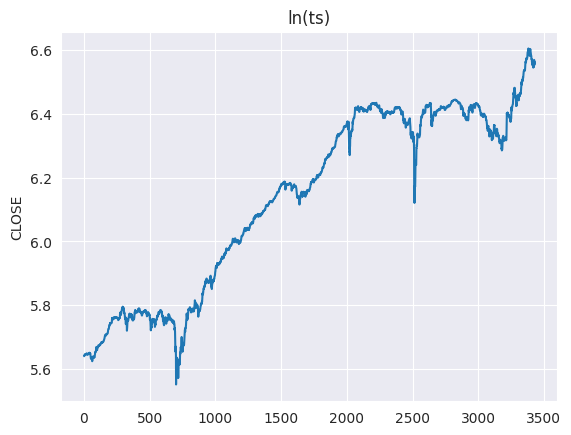

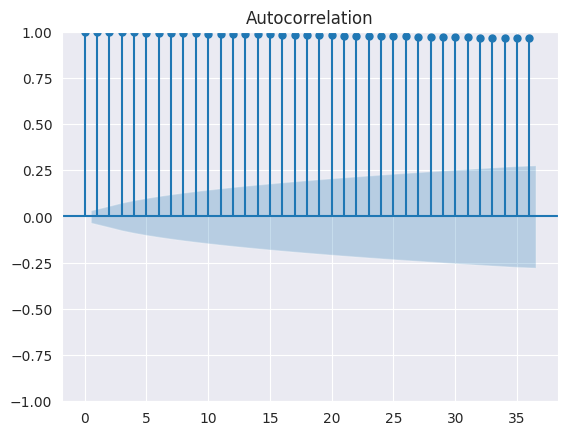

In [5]:
import statsmodels as sm
from statsmodels.tsa.stattools import acf, q_stat
from statsmodels.graphics import tsaplots

log_close = np.log(data["CLOSE"])

sns.lineplot(log_close)
plt.title("ln(ts)")
plt.show()

tsaplots.plot_acf(log_close)
plt.show()


In [6]:
import statsmodels.tsa.stattools as tst
from statsmodels.tsa.statespace.tools import diff


test_diffs = 4
n_lags = 100

for lag in range(test_diffs):
    result = tst.adfuller(diff(log_close, lag), n_lags)
    p_value = result[1]

    print(f"lag: {lag}, test unit root non stationarity: {p_value > 0.05}")


lag: 0, test unit root non stationarity: True
lag: 1, test unit root non stationarity: False
lag: 2, test unit root non stationarity: False
lag: 3, test unit root non stationarity: False


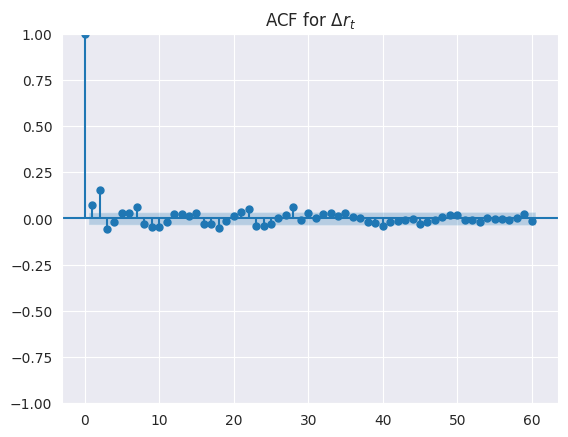

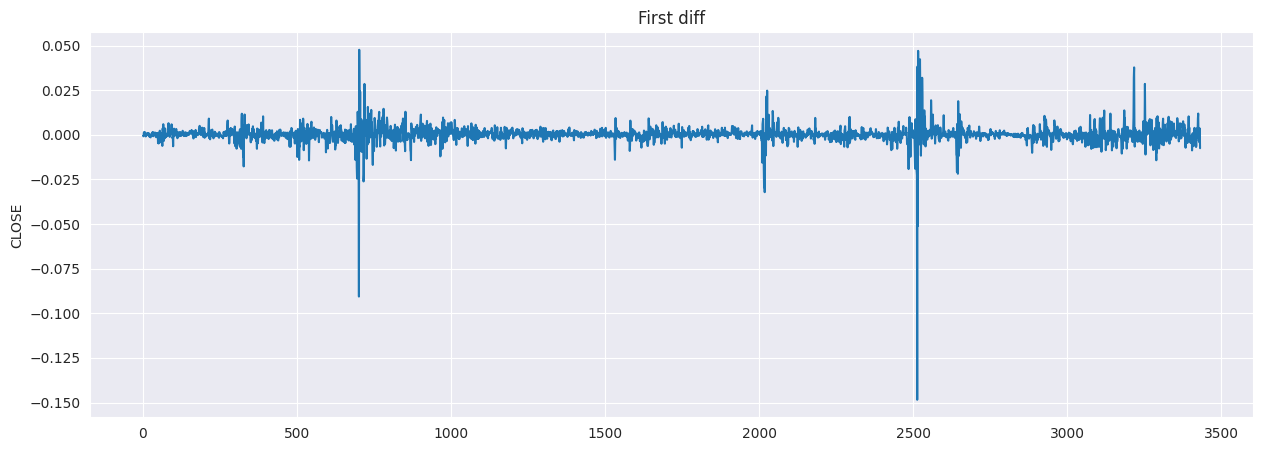

In [7]:
import statsmodels.tsa.stattools as tst

tsaplots.plot_acf(diff(log_close), lags=60)
plt.title("ACF for $\\Delta r_t$")
plt.show()

fig = plt.figure(figsize=(15, 5))
sns.lineplot(diff(log_close))
plt.title("First diff")
plt.show()


# AR

Train size: 2745/3432


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2745
Model:               SARIMAX(1, 1, 0)   Log Likelihood               10431.856
Date:                Tue, 28 Oct 2025   AIC                         -20857.713
Time:                        12:15:16   BIC                         -20839.961
Sample:                             0   HQIC                        -20851.298
                               - 2745                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      2.072      0.038    1.48e-05       0.001
ar.L1          0.0242      0.003      7.016      0.000       0.017       0.031
sigma2       2.92e-05   8.53e-08    342.387      0.000     2.9e-05    2.94e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):           6989705.11
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.70   Skew:                            -8.81
Prob(H) (two-sided):                  0.00   Kurtosis:                       249.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

{'fopt': np.float64(-3.800311960992284),
 'gopt': array([1.67537531e-01, 6.05546724e-06, 3.40503687e-01]),
 'fcalls': 172,
 'warnflag': 0,
 'converged': True,
 'iterations': 2}

<Figure size 1500x1500 with 0 Axes>

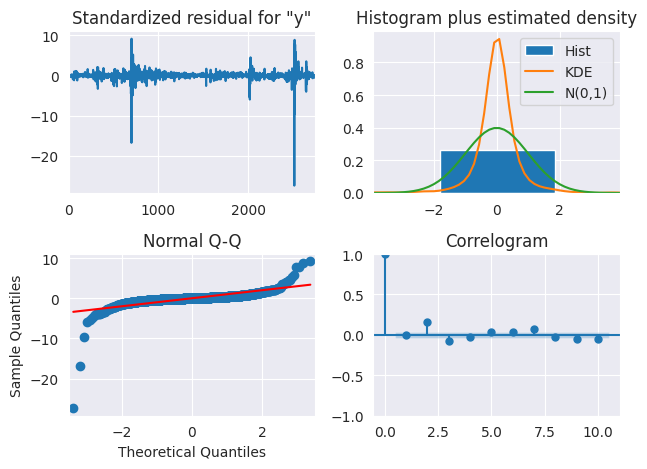

In [8]:
from statsmodels.tsa.statespace import sarimax

ts = log_close.to_numpy()

train_size = int(len(ts) * 0.8)
test_size = len(ts) - train_size

print(f"Train size: {train_size}/{len(ts)}")

model = sarimax.SARIMAX(ts[:train_size], order=(1, 1, 0), trend=[1]).fit()
display(model.summary())
display(model.mle_retvals)

fig = plt.figure(figsize=(15, 15))
model.plot_diagnostics()
plt.tight_layout()
plt.show()

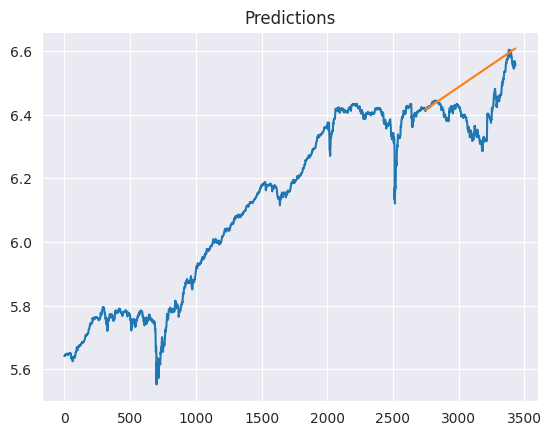

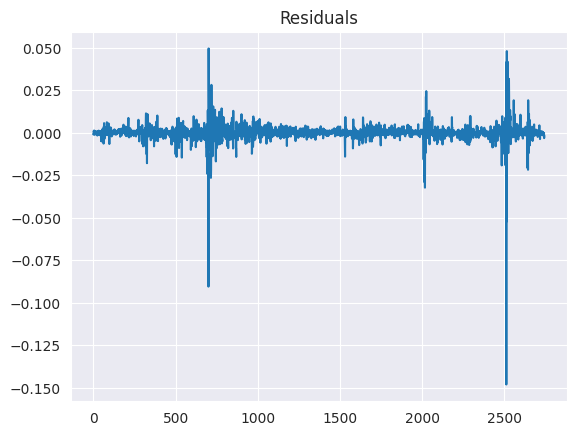

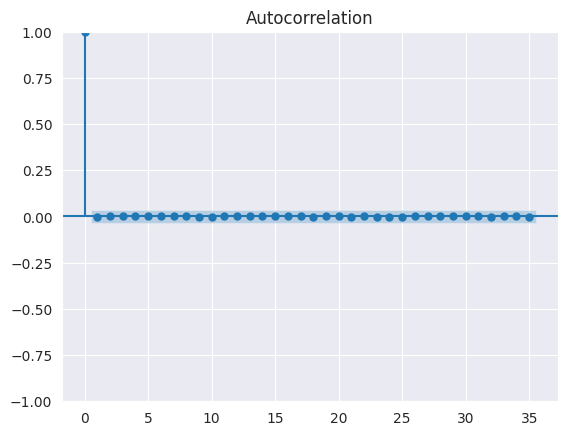

In [9]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as accuracy

preds = model.forecast(test_size)

sns.lineplot(ts)
sns.lineplot(x=range(train_size, len(ts)), y=preds)
plt.title("Predictions")
plt.show()

sns.lineplot(model.resid[1:])
plt.title("Residuals")
plt.show()

tsaplots.plot_acf(model.resid)
plt.show()

In [10]:
def running_forecast(model: sarimax.SARIMAXResults, ts, run_days, train_size):
    results = []
    model = model.apply(ts[:train_size])

    for i in range(train_size, len(ts) - run_days):
        results.append(model.forecast(run_days))
        model = model.extend([ts[i]])
    results.append(model.forecast(run_days))

    aggreg = results[0].tolist() + [res[-1] for res in results[1:]]
    return aggreg

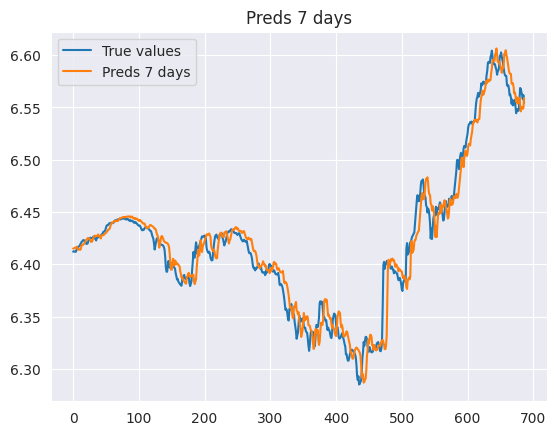

$MAPE = 0.0017$

$MAE = 0.0109$

In [11]:
days = 7
result = running_forecast(model, ts, days, train_size)
sns.lineplot(ts[train_size:], label="True values")
sns.lineplot(result, label=f"Preds {days} days")
plt.title(f"Preds {days} days")
plt.show()

res_mape = mape(ts[train_size:], result)
res_mae = mae(ts[train_size:], result)
display(Markdown(f"$MAPE = {res_mape:.4f}$"))
display(Markdown(f"$MAE = {res_mae:.4f}$"))

На растущем рынке модель недооценивает рост, на убывающем $-$ переоценивает

Это происходит из-за запаздывания, так как AR(1) это по сути фильтр скользящего среднего

# ML

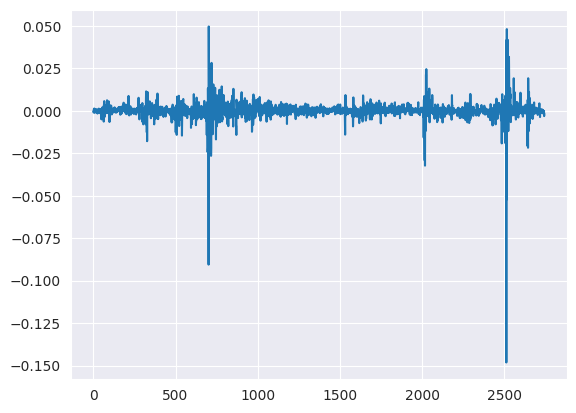

In [12]:
# removing the first gap, because it creates outlier in residuals
s = ts[0]
resid = model.resid.copy()
resid[0] -= s

sns.lineplot(resid)
plt.show()

In [13]:
import torch
import torch.nn as nn

In [21]:
print(f"Len data = {len(resid)}")

W = 300 # Берем 1 год +-
batch_size = 16

training_data_x = []
training_data_y = []
for i in range(len(resid) - W - 1):
    x = resid[i:i+W]
    y = resid[i+W]
    training_data_x.append(x)
    training_data_y.append([y])

training_data_x = torch.Tensor(np.array(training_data_x))
training_data_y = torch.Tensor(np.array(training_data_y))
dataset = torch.utils.data.TensorDataset(training_data_x, training_data_y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size, True)

sx, sy = next(iter(dataloader))
print(f"Len dataloader = {len(dataloader)}")
print(sx.shape)
print(sy.shape)

Len data = 2745
Len dataloader = 153
torch.Size([16, 300])
torch.Size([16, 1])


In [15]:
class SimpleCNN(nn.module):
    def __init__(self, window_size):
        super().__init__()
        self.
        

SyntaxError: invalid syntax (2990268459.py, line 4)